# Importar bibibliotecas

In [1]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as drv
import numpy as np
import matplotlib.pyplot as plt

# Definición del Kernel

In [2]:
source_code_Lax_Friedrichs = """
__global__ void Lax_Friedrichs(double *u_old, double *u_new, double dt_dx, int n) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;

    if (0 < i && i < n - 1)
        u_new[i] = (u_old[i-1] + u_old[i+1]) * (0.5 - 0.25*dt_dx*(u_old[i+1]-u_old[i-1]));

    if (i == 0)     u_new[i] = u_old[i+1]; // Condición de borde izquierdo
    if (i == n - 1) u_new[i] = u_old[i-1]; // Condición de borde derecho
}
"""

In [3]:
mod = SourceModule(source_code_Lax_Friedrichs)    
# Accede a las funciones del kernel
Lax_Friedrichs = mod.get_function("Lax_Friedrichs")

# Configurar las condiciones iniciales del PVI y parámetros de la EDP

In [4]:
T = np.float64(4)
L = np.float64(6)  

# Configurar parámetros de método numérico

In [ ]:
n = np.int32((1<<18))
cfl = np.float64(0.9)
# Creando Condición Inicial
cond_ini = np.zeros(n,dtype=np.float64)
cond_ini[n//4:n//2] = np.float64(1.0) 
cond_ini[:n//4] = np.float64(0.1)
 
dx = np.float64(L / n)            # Paso espacial (dominio de x de 0 a L)
dt =  np.float64(cfl*dx/np.max(cond_ini))  # Paso temporal inicial
dt_dx = np.float64(dt/dx )

# Configurar parámetros GPU

In [6]:
block_size = (1024, 1, 1)
grid_size = (int(np.ceil(2*n / block_size[0])), 1, 1)

# # Inicialización vectores máximo

#Asignar memoria en el device
old_gpu = drv.mem_alloc(cond_ini.nbytes)
new_gpu = drv.mem_alloc(cond_ini.nbytes)


#Copiar los datos del host al device
# drv.memcpy_htod(data_gpu, data)
drv.memcpy_htod(old_gpu, cond_ini)
drv.memcpy_htod(new_gpu, np.zeros(n,dtype=np.float64))

In [7]:
print("Parámetros EDP:")
print(f"  - Tiempo de simulación: {T} s")
print(f"  - Largo del dominio: {L} s")
print("\nParámetros Método Numérico:")
print(f"  - CFL: {cfl}")
print(f"  - Mallado: {n} celdas")
print(f"  - dx: {dx} [m]")
print(f"  - dt: {dt} [s]")
print("\nParámetros GPU:")
print(f"  - Memoria: {cond_ini.nbytes*2 // (1024.0 ** 2)} MB")
print(f"  - Tamaño bloque: {block_size[0]} hilos")
print(f"  - Tamaño grilla: {grid_size[0]} bloques")

Parámetros EDP:
  - Tiempo de simulación: 4.0 s
  - Largo del dominio: 6.0 s

Parámetros Método Numérico:
  - CFL: 0.9
  - Mallado: 262144 celdas
  - dx: 2.288818359375e-05 [m]
  - dt: 2.0599365234375e-05 [s]

Parámetros GPU:
  - Memoria: 4.0 MB
  - Tamaño bloque: 1024 hilos
  - Tamaño grilla: 512 bloques


# Cálculo de la solución usando el Kernel de CUDA 

In [ ]:
try:
    t=np.int32(0)
    T_actual    = 0
    soluciones  = []
    sim_guardar = 10
    modulo=int(T/dt/sim_guardar)
    times = []
    time=0

    # dt =  np.float64(cfl*dx/max(cond_ini))  # Paso temporal inicial
    # dt_dx = np.float64(dt/dx )

    while T_actual <T:
        #----------------- Actualización de data -----------------#
        Lax_Friedrichs(old_gpu,new_gpu, dt_dx, n, block=block_size, grid=grid_size)
        old_gpu, new_gpu = new_gpu, old_gpu
        
        T_actual = T_actual + dt
        
        
        time+=1
        if time % modulo ==0:
            # Copiar los datos de vuelta al host y verificar
            data = np.empty_like(cond_ini)
            drv.memcpy_dtoh(data, old_gpu)
            soluciones.append(data)
            times.append(T_actual)
finally:
    
    # Liberar la memoria
    old_gpu.free()
    new_gpu.free()
    print("Memoria liberada")

Memoria liberada


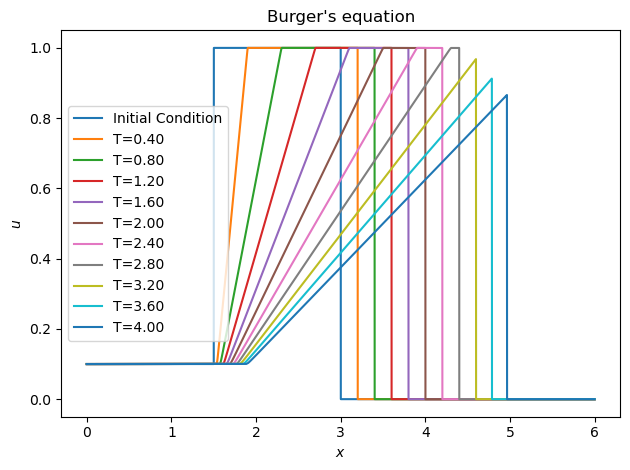

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,L,n),cond_ini[:n],label='Initial Condition')
for i in range(len(soluciones)):
    plt.plot(np.linspace(0,L,n),soluciones[i][:n],label='T=%.2f'% (times[i]))
plt.title("Burger's equation")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.legend()
plt.tight_layout()

# plt.savefig("/home/diego/Dropbox/[2024]/UCM/Victor/paper1/img/burger_sol.pdf", format="pdf")
# plt.show()


In [10]:
print(int(T/dt/10))

19418


In [3]:

import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as drv
import numpy as np

source_code_prefix = r"""
__global__ void PrefixSum(const double *a_old, double *a_new, int m)
{
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    int out_n = m /2;  // m/2

    if (i < out_n) {
        a_new[i] = a_old[2*i] + a_old[2*i + 1];
    }
}
"""
mod = SourceModule(source_code_prefix)
PrefixSum = mod.get_function("PrefixSum")

In [7]:
# Ejemplo de entrada (n = 2^l)
n = 2** 24
a = np.random.rand(n).astype(np.float64) 

# Reservar buffers (ambos de tamaño n; en cada etapa solo se usa el prefijo [0:m])
a_old_gpu = drv.mem_alloc(a.nbytes)
a_new_gpu = drv.mem_alloc(a.nbytes)

drv.memcpy_htod(a_old_gpu, a)

block = (256, 1, 1)  # 256/512 suele ir bien para reducción
m = n

try:
    while m > 1:
        out_n = m // 2
        grid = (int(np.ceil(out_n / block[0])), 1, 1)

        PrefixSum(a_old_gpu, a_new_gpu, np.int32(m), block=block, grid=grid)

        # Swap de punteros (sin copiar): a_old = a_new para el siguiente paso
        a_old_gpu, a_new_gpu = a_new_gpu, a_old_gpu
        m //= 2

    # Traer solo el primer double (resultado final)
    res_host = np.empty(1, dtype=np.float64)
    drv.memcpy_dtoh(res_host, a_old_gpu)

    resultado = float(res_host[0])
    print("Producto total =", resultado)

finally:
    a_old_gpu.free()
    a_new_gpu.free()
    print("Memoria liberada")

print(sum(a)-res_host[0])


Producto total = 8389538.014660748
Memoria liberada
-5.662441253662109e-07
